In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Tests
- Benchmarking: Mean, Regression, DNNs
- Donor selection: Clustering on similarity - DTW / Initiles Alignment der Gebäude/ New Features (Weather + Price) / Correlation analysis / Synthetic data generation + Diverse
- Weight selection: Different Norms / New Constraints / Slack variables / Regularization
- Day Types: Unterschiedliche Kontroll Gruppen je Tag 

In [2]:
# 1. Prepare Data
def prepare_data_for_synthetic_control(path):
    # Step 1: Load the dataset
    df = pd.read_csv(path, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)

    # Step 2: Drop 'load_*' columns with any missing values
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")
    df = df[['Date'] + clean_loads]

    # Step 2: Select the treated and control units
    treated_unit = df.columns[1]
    control_units = [col for col in df.columns if col.startswith('load_') and col != treated_unit]

    # Step 3: Define pre-treatment and post-treatment periods
    split_index = int(len(df) * 0.8)  # 80% for pre-treatment
    pre_treatment, post_treatment = df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

    # Step 5: Prepare the data matrices
    Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
    Y0_pre = pre_treatment[control_units].values.T  # Shape: (J, T0)

    Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
    Y0_post = post_treatment[control_units].values.T  # Shape: (J, T1)

    return Y1_pre, Y0_pre, Y1_post, Y0_post

Y1_pre, Y0_pre, Y1_post, Y0_post = prepare_data_for_synthetic_control("../../data/Final_Energy_dataset.csv")

Dropped load columns with missing values: {'load_2'}


# Benchmarking

MOVING AVERAGE - Post-Treatment Error Metrics:
MSE: 0.069807400293386 RMSE: 0.2642109011630406 MAE: 0.17110819276035985


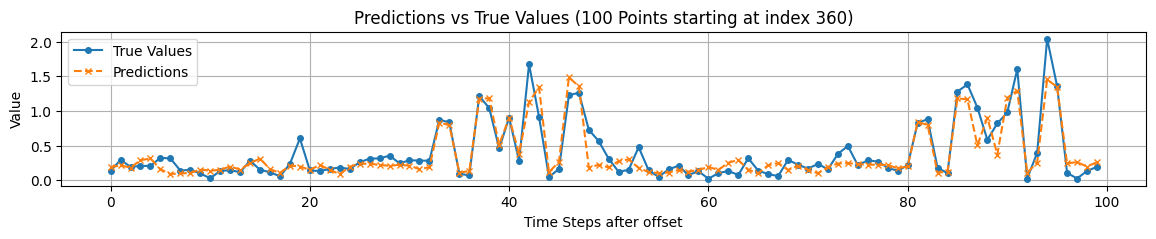

In [166]:
def plot_predictions(predictions, true_values, offset=360, num_points=3*48):

    # Create x-axis values for the subset we want to plot
    x_values = range(num_points)
    
    # Get the subsequences we want to plot
    true_subset = true_values[offset:offset+num_points]
    pred_subset = predictions[offset:offset+num_points]
    
    plt.figure(figsize=(14, 2))
    plt.plot(x_values, true_subset, label='True Values', marker='o', linestyle='-', markersize=4)
    plt.plot(x_values, pred_subset, label='Predictions', marker='x', linestyle='--', markersize=4)
    plt.title(f"Predictions vs True Values ({num_points} Points starting at index {offset})")
    plt.xlabel('Time Steps after offset')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

def calculate_moving_average_same_time(series, window_days=10):
    """
    Calculate moving average using only historical values from the same time of day
    """
    values = series.values
    result = np.zeros_like(values)
    periods_per_day = 48
    
    # Print some sample calculations for verification
    sample_indices = [100, 148, 196]
    #print("\nSample value verification:")
    #print(f"Values at indices {sample_indices}:")
    #for idx in sample_indices:
        #print(f"Index {idx}: {values[idx]}")
    
    # For each position in the array
    for i in range(len(values)):
        # Find indices for the same time of day in previous days only
        indices = [i - (j * periods_per_day) for j in range(1, window_days + 1)]
        valid_indices = [idx for idx in indices if idx >= 0]
        
        # Print detailed calculation for sample points
        #if i in sample_indices:
        #    print(f"\nDetailed calculation for index {i}:")
        #    print(f"Looking back indices: {valid_indices}")
        #    print(f"Values used: {[values[idx] for idx in valid_indices]}")
        #    print(f"Number of values used: {len(valid_indices)}")
        
        if valid_indices:
            result[i] = np.mean([values[idx] for idx in valid_indices])
        else:
            # If no historical data available, we could either:
            # 1. Use the current value
            # 2. Use some default value
            # 3. Mark it as NaN
            result[i] = values[i]  # Using option 1 for now
    
    return result

def moving_average_load_estimation(Y1_pre, Y1_post,window=10):
    results = {}

    # Convert to pandas Series for rolling operations
    Y1_pre_series = pd.Series(Y1_pre)
    Y1_post_series = pd.Series(Y1_post)

    # Pre-Treatment Period 
    #Y1_pre_estimated = Y1_pre_series.rolling(window=window, min_periods=1).mean().values
    Y1_pre_estimated = calculate_moving_average_same_time(Y1_pre_series, window_days=10)
    mse_pre = np.mean((Y1_pre - Y1_pre_estimated) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y1_pre_estimated))

    results['pre_treatment'] = {'MSE': mse_pre,'RMSE': rmse_pre,'MAE': mae_pre}

    # Post-Treatment Period
    #Y1_post_estimated = Y1_post_series.rolling(window=window, min_periods=1).mean().values
    Y1_post_estimated = calculate_moving_average_same_time(Y1_post_series, window_days=10)
    mse_post = np.mean((Y1_post - Y1_post_estimated) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y1_post_estimated))

    results['post_treatment'] = {
        'MSE': mse_post,
        'RMSE': rmse_post,
        'MAE': mae_post
    }

    return results, Y1_post_estimated, Y1_post_series

error_metrics_ma, predictions, y_test_actual = moving_average_load_estimation(Y1_pre, Y1_post, window=10)

print("MOVING AVERAGE - Post-Treatment Error Metrics:")
print(f"MSE: {error_metrics_ma['post_treatment']['MSE']}", f"RMSE: {error_metrics_ma['post_treatment']['RMSE']}", f"MAE: {error_metrics_ma['post_treatment']['MAE']}")

plot_predictions(predictions, y_test_actual, num_points=100)

In [1]:
def train_evaluate_lstm(Y1_pre, Y1_post, epochs=50, batch_size=64):
    results = {}
    # Combine pre and post data for scaling
    full_data = np.concatenate([Y1_pre, Y1_post], axis=0).reshape(-1, 1)
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(full_data)
    
    # Split back into pre and post
    scaled_pre = scaled_data[:len(Y1_pre)]
    scaled_post = scaled_data[len(Y1_pre):]
    
    # Function to create sequences
    def create_sequences(data, window):
        X, y = [], []
        for i in range(len(data) - window):
            X.append(data[i:i+window])
            y.append(data[i+window])
        return np.array(X), np.array(y)
    
    # Create training sequences from pre-treatment data
    X_train, y_train = create_sequences(scaled_pre, 48)
    
    # Reshape for LSTM [samples, time_steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Create test sequences from pre + post data to predict post
    combined = np.concatenate([scaled_pre, scaled_post], axis=0)
    X_test, y_test = create_sequences(combined, 48)
    
    # Only keep the sequences that correspond to the post-treatment period
    X_test = X_test[-len(Y1_post):]
    y_test = y_test[-len(Y1_post):]
    
    # Reshape for LSTM
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(8, activation='relu', input_shape=(48, 1), return_sequences=True))  # First LSTM layer
    model.add(LSTM(8, activation='relu'))  # Second LSTM layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions)

    results['post_treatment'] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    return results, predictions, y_test_actual

error_metrics_lstm, predictions, y_test_actual = train_evaluate_lstm(Y1_pre, Y1_post, epochs=100)

print("LSTM - Post-Treatment Error Metrics:")
print(f"MSE: {error_metrics_lstm['post_treatment']['MSE']}", f"RMSE: {error_metrics_lstm['post_treatment']['RMSE']}", f"MAE: {error_metrics_lstm['post_treatment']['MAE']}")

# Plot the first 100 predictions and true values
plot_predictions(predictions, y_test_actual, num_points=3*48)

NameError: name 'Y1_pre' is not defined

# 1. Synthetic Control - Basic

Set parameter Username
Set parameter LicenseID to value 2593432
Academic license - for non-commercial use only - expires 2025-11-30
Post-Treatment Metrics: {'MSE': 0.195, 'RMSE': 0.4416, 'MAE': 0.3518}
Number of weights > 0.0: 298


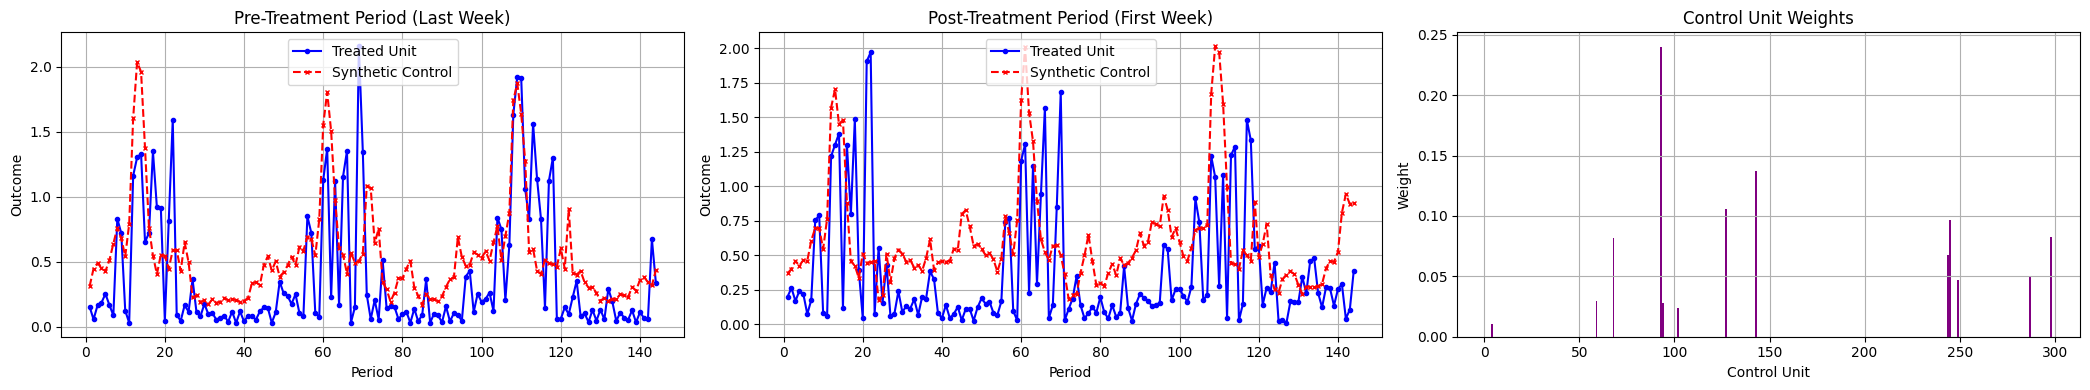

In [3]:
# 2. Compute optimal weights
def compute_synthetic_control_weights_L2(Y1_pre, Y0_pre):
    """
    Computes synthetic control weights using Gurobi.

    Parameters:
    - Y1_pre: numpy array of shape (T0,), the pre-treatment outcomes of the treated unit.
    - Y0_pre: numpy array of shape (J, T0), the pre-treatment outcomes of control units.

    Returns:
    - W_opt: numpy array of shape (J,), the optimal weights for the control units.
    """
    
    T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
    J = Y0_pre.shape[0]   # Number of control units

    # Compute Q matrix for the quadratic term: Q = Y0_pre @ Y0_pre.T
    Q = Y0_pre @ Y0_pre.T

    # Compute c vector for the linear term: c = -2 * Y0_pre @ Y1_pre
    c = -2 * Y0_pre @ Y1_pre

    # Create a Gurobi model
    model = gp.Model()
    model.setParam('OutputFlag', 0) # Suppress Gurobi output

    # Add variables W_j >= 0 for each control unit
    W = model.addVars(J, lb=0.0, name="W")

    # Add the constraint that the weights sum to one
    model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

    # Set the objective function to minimize (1/2) * W^T * Q * W + c^T * W
    obj = (0.5 * gp.quicksum(Q[i, j] * W[i] * W[j] for i in range(J) for j in range(J))
           + gp.quicksum(c[j] * W[j] for j in range(J)))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Retrieve the optimal weights
    W_opt = np.array([W[j].X for j in range(J)])

    return W_opt
weights = compute_synthetic_control_weights_L2(Y1_pre, Y0_pre)

#3. Calculate synthetic control data
def compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights):
    Y_synthetic_pre = np.dot(weights, Y0_pre)
    Y_synthetic_post = np.dot(weights, Y0_post)  # Shape: (T1,)
    return Y_synthetic_pre, Y_synthetic_post
Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights)

#4. Evaluate and plot
def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
    # Calculate metrics for pre-treatment
    mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
    metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
    
    # Calculate metrics for post-treatment
    mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
    metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
    
    return metrics_pre, metrics_post

metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
#print("Pre-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_pre.items()})
print("Post-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_post.items()})
print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
    periods_to_plot = 3*48  # Number of periods to represent one week
    
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
    
    post_treatment_actual = Y1_post[:periods_to_plot]
    post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Third Subplot: Weights Values
    axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
    axes[2].set_title('Control Unit Weights')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

# 2. Synthetic Control - L1 Norm

Set parameter Username
Set parameter LicenseID to value 2593432
Academic license - for non-commercial use only - expires 2025-11-30
Post-Treatment Metrics: {'MSE': 0.1278, 'RMSE': 0.3574, 'MAE': 0.2279}
Number of weights > 0.0: 27


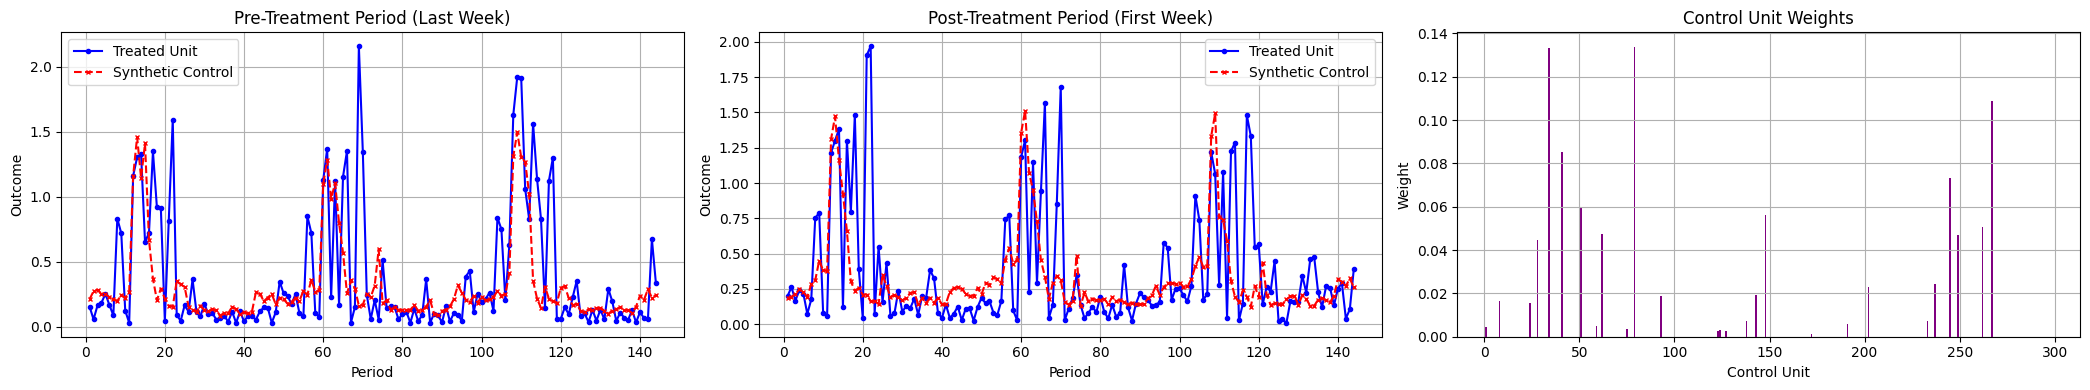

In [4]:
# 2. Compute optimal weights
def compute_synthetic_control_weights_L1(Y1_pre, Y0_pre):
    # Ensure proper shapes
    Y1_pre = np.asarray(Y1_pre)
    Y0_pre = np.asarray(Y0_pre)
    
    T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
    J = Y0_pre.shape[0]   # Number of control units

    # Create a Gurobi model
    model = gp.Model("Synthetic_Control_L1")
    model.setParam('OutputFlag', 0) # Suppress Gurobi output

    # Add variables W_j >= 0 for each control unit
    W = model.addVars(J, lb=0.0, name="W")

    # Add auxiliary variables e_plus_t >= 0 and e_minus_t >=0 for each pre-treatment period
    e_plus = model.addVars(T0, lb=0.0, name="e_plus")
    e_minus = model.addVars(T0, lb=0.0, name="e_minus")

    # Add the constraint that the weights sum to one
    model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

    # Add constraints to define e_plus and e_minus
    for t in range(T0):
        # Calculate the discrepancy: Y1_pre[t] - sum_j W[j] * Y0_pre[j, t]
        discrepancy = Y1_pre[t] - gp.quicksum(W[j] * Y0_pre[j, t] for j in range(J))
        # Enforce discrepancy = e_plus[t] - e_minus[t]
        model.addConstr(discrepancy == e_plus[t] - e_minus[t], name=f"discrepancy_{t}")

    # Set the objective function to minimize the sum of e_plus and e_minus
    obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimal weights
        W_opt = np.array([W[j].X for j in range(J)])
        return W_opt
    else:
        raise ValueError("Optimization was not successful. Please check the model and data.")
weights = compute_synthetic_control_weights_L1(Y1_pre, Y0_pre)

#3. Calculate synthetic control data
def compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights):
    Y_synthetic_pre = np.dot(weights, Y0_pre)
    Y_synthetic_post = np.dot(weights, Y0_post)  # Shape: (T1,)
    return Y_synthetic_pre, Y_synthetic_post
Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights)

#4. Evaluate and plot
def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
    # Calculate metrics for pre-treatment
    mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
    metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
    
    # Calculate metrics for post-treatment
    mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
    metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
    
    return metrics_pre, metrics_post

metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
#print("Pre-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_pre.items()})
print("Post-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_post.items()})
print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
    periods_to_plot = 3*48  # Number of periods to represent one week
    
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
    
    post_treatment_actual = Y1_post[:periods_to_plot]
    post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Third Subplot: Weights Values
    axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
    axes[2].set_title('Control Unit Weights')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

# 3 Synthetic Control - Donor Selection

### 3.0 Synthetic Control - Time Shifted Donors

In [12]:
def prepare_data_for_synthetic_control_with_time_laged_control_groups(path, num_shifts=3):
    """
    Prepare data for synthetic control method with variable number of time shifts.
    
    Args:
        path (str): Path to the CSV file containing the data
        num_shifts (int): Number of shifts in each direction (forward and backward). Default is 3.
                         Total number of versions per control unit will be (2 * num_shifts + 1)
                         
    Returns:
        tuple: (Y1_pre, Y0_pre, Y1_post, Y0_post) matrices for synthetic control method
    """
    # Step 1: Load the dataset
    df = pd.read_csv(path, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
    
    # Step 2: Drop 'load_*' columns with any missing values
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")
    
    # Step 3: Initialize the enhanced dataframe with treated unit
    treated_unit = clean_loads[0]  # First load column is treated unit
    control_units = clean_loads[1:]  # Rest are control units
    
    # Create a dictionary to store all the shifted data
    data_dict = {'Date': df['Date'], treated_unit: df[treated_unit]}
    
    # Add original and shifted versions for each control unit
    for control in control_units:
        # Add original version
        data_dict[f"{control}_orig"] = df[control]
        
        # Add backward shifts
        for i in range(1, num_shifts + 1):
            data_dict[f"{control}_backward_{i}"] = df[control].shift(-i)
            
        # Add forward shifts
        for i in range(1, num_shifts + 1):
            data_dict[f"{control}_forward_{i}"] = df[control].shift(i)
    
    # Create enhanced DataFrame all at once to avoid fragmentation
    enhanced_df = pd.DataFrame(data_dict)
    
    # Drop rows with NaN values due to shifting
    enhanced_df = enhanced_df.dropna()
    
    # Get control column names with suffixes
    all_control_units = []
    for control in control_units:
        # Add original version
        all_control_units.append(f"{control}_orig")
        
        # Add all backward shifts
        all_control_units.extend([f"{control}_backward_{i}" for i in range(1, num_shifts + 1)])
        
        # Add all forward shifts
        all_control_units.extend([f"{control}_forward_{i}" for i in range(1, num_shifts + 1)])
    
    # Print information about the dataset
    total_versions = 2 * num_shifts + 1
    print(f"Number of control units: {len(control_units)}")
    print(f"Versions per control unit: {total_versions} ({num_shifts} backward, 1 original, {num_shifts} forward)")
    print(f"Total number of control unit versions: {len(all_control_units)}")
    
    # Step 4: Define pre-treatment and post-treatment periods
    split_index = int(len(enhanced_df) * 0.8)  # 80% for pre-treatment
    pre_treatment = enhanced_df.iloc[:split_index].copy()
    post_treatment = enhanced_df.iloc[split_index:].copy()
    
    # Step 5: Prepare the data matrices
    Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
    Y0_pre = pre_treatment[all_control_units].values.T  # Shape: ((2*num_shifts+1)*J, T0)
    
    Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
    Y0_post = post_treatment[all_control_units].values.T  # Shape: ((2*num_shifts+1)*J, T1)
    
    return Y1_pre, Y0_pre, Y1_post, Y0_post

Y1_pre, Y0_pre, Y1_post, Y0_post = prepare_data_for_synthetic_control_with_time_laged_control_groups("../../data/Final_Energy_dataset.csv")

Dropped load columns with missing values: {'load_2'}
Number of control units: 298
Versions per control unit: 7 (3 backward, 1 original, 3 forward)
Total number of control unit versions: 2086


Post-Treatment Metrics: {'MSE': 0.1129, 'RMSE': 0.336, 'MAE': 0.2155}
Number of weights > 0.0: 40


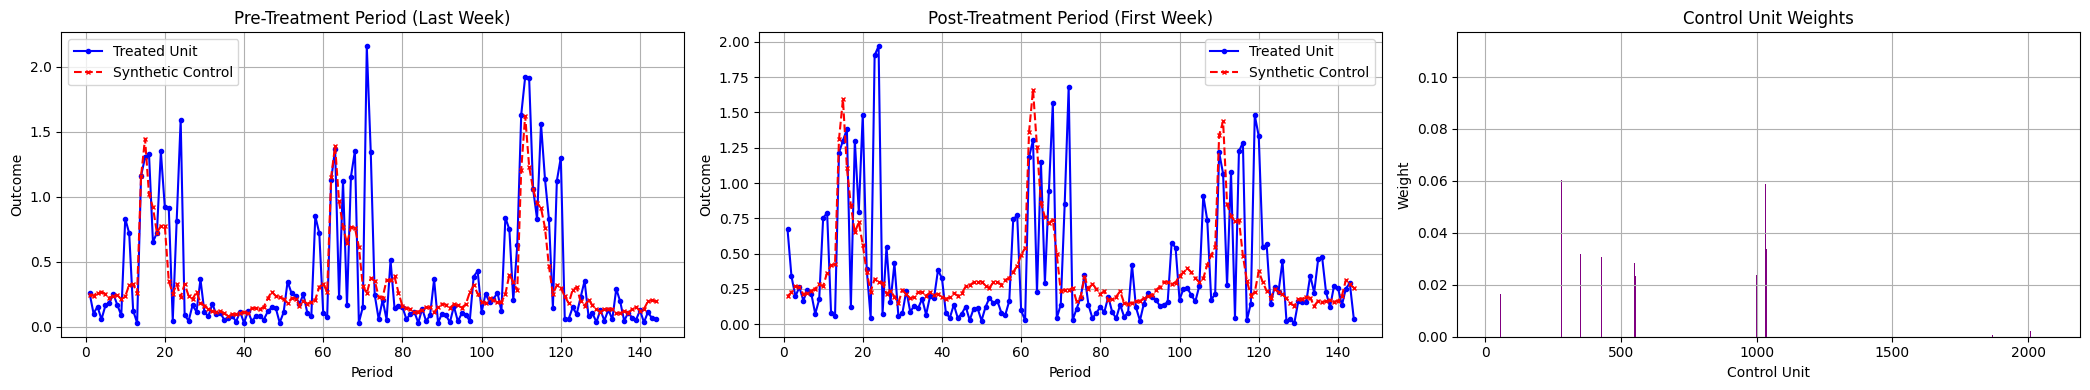

In [169]:
# 2. Compute optimal weights
def compute_synthetic_control_weights_L1(Y1_pre, Y0_pre):
    # Ensure proper shapes
    Y1_pre = np.asarray(Y1_pre)
    Y0_pre = np.asarray(Y0_pre)
    
    T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
    J = Y0_pre.shape[0]   # Number of control units

    # Create a Gurobi model
    model = gp.Model("Synthetic_Control_L1")
    model.setParam('OutputFlag', 0) # Suppress Gurobi output

    # Add variables W_j >= 0 for each control unit
    W = model.addVars(J, lb=0.0, name="W")

    # Add auxiliary variables e_plus_t >= 0 and e_minus_t >=0 for each pre-treatment period
    e_plus = model.addVars(T0, lb=0.0, name="e_plus")
    e_minus = model.addVars(T0, lb=0.0, name="e_minus")

    # Add the constraint that the weights sum to one
    model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

    # Add constraints to define e_plus and e_minus
    for t in range(T0):
        # Calculate the discrepancy: Y1_pre[t] - sum_j W[j] * Y0_pre[j, t]
        discrepancy = Y1_pre[t] - gp.quicksum(W[j] * Y0_pre[j, t] for j in range(J))
        # Enforce discrepancy = e_plus[t] - e_minus[t]
        model.addConstr(discrepancy == e_plus[t] - e_minus[t], name=f"discrepancy_{t}")

    # Set the objective function to minimize the sum of e_plus and e_minus
    obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimal weights
        W_opt = np.array([W[j].X for j in range(J)])
        return W_opt
    else:
        raise ValueError("Optimization was not successful. Please check the model and data.")
weights = compute_synthetic_control_weights_L1(Y1_pre, Y0_pre)

#3. Calculate synthetic control data
def compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights):
    Y_synthetic_pre = np.dot(weights, Y0_pre)
    Y_synthetic_post = np.dot(weights, Y0_post)  # Shape: (T1,)
    return Y_synthetic_pre, Y_synthetic_post
Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights)

#4. Evaluate and plot
def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
    # Calculate metrics for pre-treatment
    mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
    metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
    
    # Calculate metrics for post-treatment
    mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
    metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
    
    return metrics_pre, metrics_post

metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
#print("Pre-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_pre.items()})
print("Post-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_post.items()})
print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
    periods_to_plot = 3*48  # Number of periods to represent one week
    
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
    
    post_treatment_actual = Y1_post[:periods_to_plot]
    post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Third Subplot: Weights Values
    axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
    axes[2].set_title('Control Unit Weights')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

### 3.1 Synthetic Control - New Features

Dropped load columns with missing values: {'load_2'}
Post-Treatment Metrics: {'MSE': 0.1267, 'RMSE': 0.3559, 'MAE': 0.2277}
Number of weights > 0.0: 28


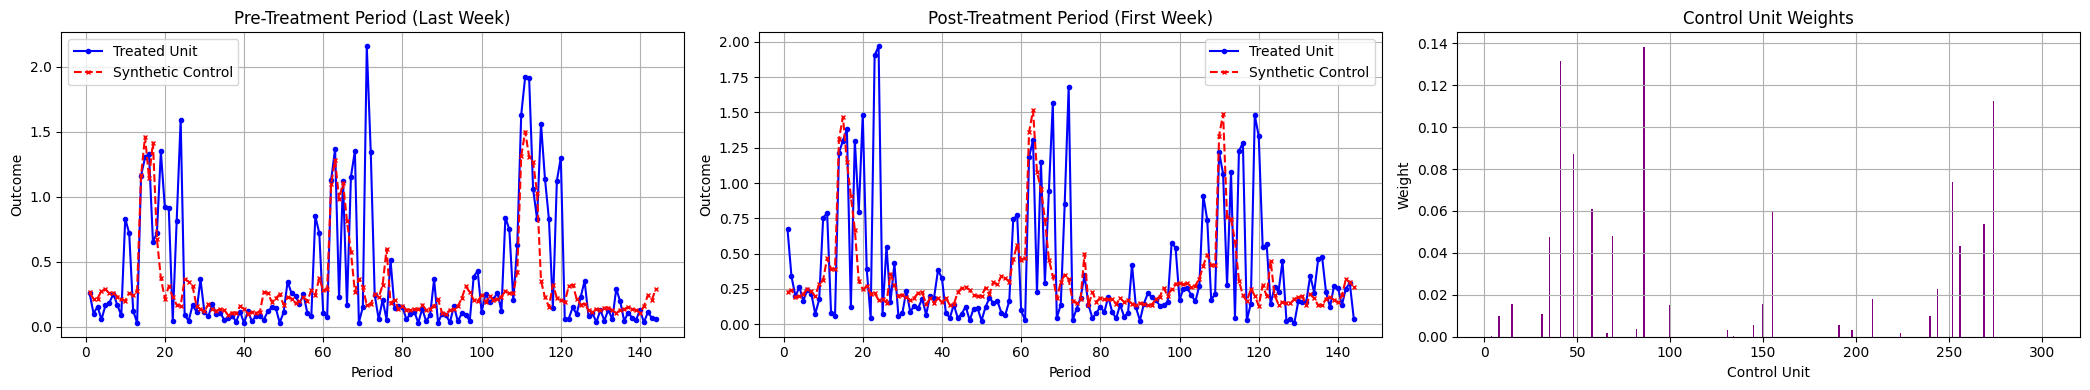

In [122]:
def prepare_data_for_synthetic_control(energy_path, weather_path):
    # Step 1: Load and merge datasets
    energy_df = pd.read_csv(energy_path, parse_dates=['Date']).sort_values('Date')
    weather_df = pd.read_csv(weather_path, parse_dates=['time'])

    # Drop the unnamed column if it exists
    if 'Unnamed: 0' in weather_df.columns:
        weather_df = weather_df.drop(columns=['Unnamed: 0'])

    # Set 'time' as the index
    weather_df = weather_df.set_index('time')

    # Sort the index
    weather_df = weather_df.sort_index()

    # Resample to 30-minute intervals and interpolate
    weather_df_resampled = weather_df.resample('30min').interpolate(method='time')

    # Reset the index if needed for further processing
    weather_df_resampled = weather_df_resampled.reset_index()
    
    # Merge datasets
    df = pd.merge(energy_df, weather_df_resampled, left_on='Date', right_on='time', how='left')
    
    # Reorder columns
    weather_columns = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
    other_columns = [col for col in df.columns if col not in weather_columns + ['Date', 'time', 'price']]
    df = df[['Date', 'price'] + weather_columns + other_columns].iloc[:-2]

    # Step 2: Handle missing values in load columns
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")

    # Keep only necessary columns
    df = df[['Date', 'price'] + weather_columns + clean_loads]

    # Step 3: Select the treated and control units
    treated_unit = clean_loads[0]  # Assuming the first load column is the treated unit
    control_units = ['price'] + weather_columns + clean_loads[1:]  # Include price, weather, and other loads

    # Step 4: Define pre-treatment and post-treatment periods
    split_index = int(len(df) * 0.8)  # 80% for pre-treatment
    pre_treatment, post_treatment = df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

    # Step 5: Prepare the data matrices
    Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
    Y0_pre = pre_treatment[control_units].values.T  # Shape: (J, T0)

    Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
    Y0_post = post_treatment[control_units].values.T  # Shape: (J, T1)

    return Y1_pre, Y0_pre, Y1_post, Y0_post, treated_unit, control_units

Y1_pre, Y0_pre, Y1_post, Y0_post, treated_unit, control_units = prepare_data_for_synthetic_control("../../data/Final_Energy_dataset.csv", "../../data/Weather_data_hourly.csv")

# 2. Compute optimal weights
def compute_synthetic_control_weights_L1(Y1_pre, Y0_pre):
    # Ensure proper shapes
    Y1_pre = np.asarray(Y1_pre)
    Y0_pre = np.asarray(Y0_pre)
    
    T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
    J = Y0_pre.shape[0]   # Number of control units

    # Create a Gurobi model
    model = gp.Model("Synthetic_Control_L1")
    model.setParam('OutputFlag', 0) # Suppress Gurobi output

    # Add variables W_j >= 0 for each control unit
    W = model.addVars(J, lb=0.0, name="W")

    # Add auxiliary variables e_plus_t >= 0 and e_minus_t >=0 for each pre-treatment period
    e_plus = model.addVars(T0, lb=0.0, name="e_plus")
    e_minus = model.addVars(T0, lb=0.0, name="e_minus")

    # Add the constraint that the weights sum to one
    model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

    # Add constraints to define e_plus and e_minus
    for t in range(T0):
        # Calculate the discrepancy: Y1_pre[t] - sum_j W[j] * Y0_pre[j, t]
        discrepancy = Y1_pre[t] - gp.quicksum(W[j] * Y0_pre[j, t] for j in range(J))
        # Enforce discrepancy = e_plus[t] - e_minus[t]
        model.addConstr(discrepancy == e_plus[t] - e_minus[t], name=f"discrepancy_{t}")

    # Set the objective function to minimize the sum of e_plus and e_minus
    obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimal weights
        W_opt = np.array([W[j].X for j in range(J)])
        return W_opt
    else:
        raise ValueError("Optimization was not successful. Please check the model and data.")
weights = compute_synthetic_control_weights_L1(Y1_pre, Y0_pre)

#3. Calculate synthetic control data
def compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights):
    Y_synthetic_pre = np.dot(weights, Y0_pre)
    Y_synthetic_post = np.dot(weights, Y0_post)  # Shape: (T1,)
    return Y_synthetic_pre, Y_synthetic_post
Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights)

#4. Evaluate and plot
def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
    # Calculate metrics for pre-treatment
    mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
    metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
    
    # Calculate metrics for post-treatment
    mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
    metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
    
    return metrics_pre, metrics_post

metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
#print("Pre-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_pre.items()})
print("Post-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_post.items()})
print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
    periods_to_plot = 3*48  # Number of periods to represent one week
    
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
    
    post_treatment_actual = Y1_post[:periods_to_plot]
    post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Third Subplot: Weights Values
    axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
    axes[2].set_title('Control Unit Weights')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

### 3.2 Synthetic Control - Include Intercept

In [136]:
# 1. Prepare Data
def prepare_data_for_synthetic_control(path):
    # Step 1: Load the dataset
    df = pd.read_csv(path, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)

    # Step 2: Drop 'load_*' columns with any missing values
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")
    df = df[['Date'] + clean_loads]

    # Step 2: Select the treated and control units
    treated_unit = df.columns[1]
    control_units = [col for col in df.columns if col.startswith('load_') and col != treated_unit]

    # Step 3: Define pre-treatment and post-treatment periods
    split_index = int(len(df) * 0.8)  # 80% for pre-treatment
    pre_treatment, post_treatment = df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

    # Step 5: Prepare the data matrices
    Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
    Y0_pre = pre_treatment[control_units].values.T  # Shape: (J, T0)

    Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
    Y0_post = post_treatment[control_units].values.T  # Shape: (J, T1)

    return Y1_pre, Y0_pre, Y1_post, Y0_post

#Y1_pre, Y0_pre, Y1_post, Y0_post = prepare_data_for_synthetic_control("../../data/Final_Energy_dataset.csv")

def prepare_data_for_synthetic_control_with_weather_and_prices(energy_path, weather_path):
    # Step 1: Load and merge datasets
    energy_df = pd.read_csv(energy_path, parse_dates=['Date']).sort_values('Date')
    weather_df = pd.read_csv(weather_path, parse_dates=['time'])

    # Drop the unnamed column if it exists
    if 'Unnamed: 0' in weather_df.columns:
        weather_df = weather_df.drop(columns=['Unnamed: 0'])

    # Set 'time' as the index
    weather_df = weather_df.set_index('time')

    # Sort the index
    weather_df = weather_df.sort_index()

    # Resample to 30-minute intervals and interpolate
    weather_df_resampled = weather_df.resample('30min').interpolate(method='time')

    # Reset the index if needed for further processing
    weather_df_resampled = weather_df_resampled.reset_index()
    
    # Merge datasets
    df = pd.merge(energy_df, weather_df_resampled, left_on='Date', right_on='time', how='left')
    
    # Reorder columns
    weather_columns = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
    other_columns = [col for col in df.columns if col not in weather_columns + ['Date', 'time', 'price']]
    df = df[['Date', 'price'] + weather_columns + other_columns].iloc[:-2]

    # Step 2: Handle missing values in load columns
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")

    # Keep only necessary columns
    df = df[['Date', 'price'] + weather_columns + clean_loads]

    # Step 3: Select the treated and control units
    treated_unit = clean_loads[0]  # Assuming the first load column is the treated unit
    control_units = ['price'] + weather_columns + clean_loads[1:]  # Include price, weather, and other loads

    # Step 4: Define pre-treatment and post-treatment periods
    split_index = int(len(df) * 0.8)  # 80% for pre-treatment
    pre_treatment, post_treatment = df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

    # Step 5: Prepare the data matrices
    Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
    Y0_pre = pre_treatment[control_units].values.T  # Shape: (J, T0)

    Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
    Y0_post = post_treatment[control_units].values.T  # Shape: (J, T1)

    return Y1_pre, Y0_pre, Y1_post, Y0_post

Y1_pre, Y0_pre, Y1_post, Y0_post = prepare_data_for_synthetic_control_with_weather_and_prices("../../data/Final_Energy_dataset.csv", "../../data/Weather_data_hourly.csv")

Dropped load columns with missing values: {'load_2'}


Post-Treatment Metrics: {'MSE': 0.1233, 'RMSE': 0.3512, 'MAE': 0.2268}
Number of weights > 0.0: 34


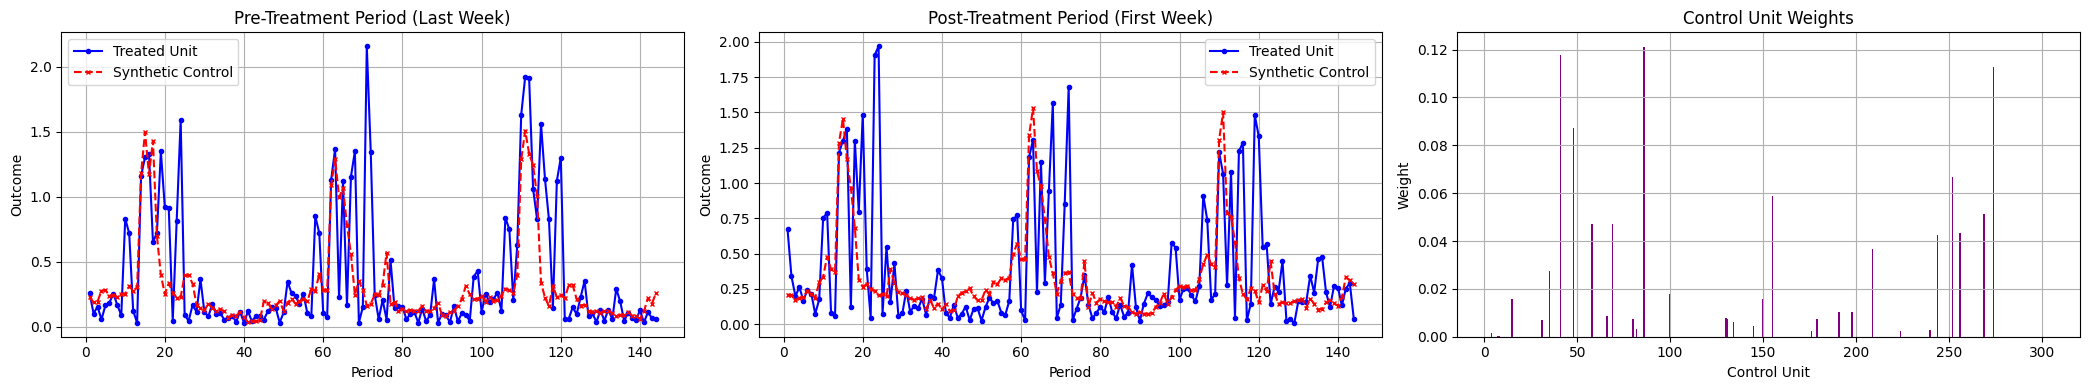

In [137]:
# 2. Compute optimal weights
def compute_synthetic_control_weights_L1_with_intercept(Y1_pre, Y0_pre):
    # Ensure proper shapes
    Y1_pre = np.asarray(Y1_pre)
    Y0_pre = np.asarray(Y0_pre)
    
    T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
    J = Y0_pre.shape[0]   # Number of control units

    # Create a Gurobi model
    model = gp.Model("Synthetic_Control_L1_with_intercept")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Add variables W_j >= 0 for each control unit
    W = model.addVars(J, lb=0.0, name="W")
    
    # Add an intercept term (can be positive or negative)
    intercept = model.addVar(lb=-float('inf'), ub=float('inf'), name="intercept")

    # Add auxiliary variables e_plus_t >= 0 and e_minus_t >=0 for each pre-treatment period
    e_plus = model.addVars(T0, lb=0.0, name="e_plus")
    e_minus = model.addVars(T0, lb=0.0, name="e_minus")

    # Add the constraint that the weights sum to one
    model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

    # Add constraints to define e_plus and e_minus, now including intercept
    for t in range(T0):
        # Calculate the discrepancy: Y1_pre[t] - (intercept + sum_j W[j] * Y0_pre[j, t])
        discrepancy = Y1_pre[t] - (intercept + gp.quicksum(W[j] * Y0_pre[j, t] for j in range(J)))
        # Enforce discrepancy = e_plus[t] - e_minus[t]
        model.addConstr(discrepancy == e_plus[t] - e_minus[t], name=f"discrepancy_{t}")

    # Set the objective function to minimize the sum of e_plus and e_minus
    obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimal weights and intercept
        W_opt = np.array([W[j].X for j in range(J)])
        intercept_opt = intercept.X
        return W_opt, intercept_opt
    else:
        raise ValueError("Optimization was not successful. Please check the model and data.")

weights, intercept = compute_synthetic_control_weights_L1_with_intercept(Y1_pre, Y0_pre)

#3. Calculate synthetic control data
def compute_synthetic_pre_post_treatment_with_intercept(Y0_pre, Y0_post, weights, intercept):
    Y_synthetic_pre = intercept + np.dot(weights, Y0_pre)
    Y_synthetic_post = intercept + np.dot(weights, Y0_post)
    return Y_synthetic_pre, Y_synthetic_post
Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment_with_intercept(Y0_pre, Y0_post, weights, intercept)

#4. Evaluate and plot
def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
    # Calculate metrics for pre-treatment
    mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
    metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
    
    # Calculate metrics for post-treatment
    mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
    metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
    
    return metrics_pre, metrics_post

metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
#print("Pre-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_pre.items()})
print("Post-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_post.items()})
print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
    periods_to_plot = 3*48  # Number of periods to represent one week
    
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
    
    post_treatment_actual = Y1_post[:periods_to_plot]
    post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Third Subplot: Weights Values
    axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
    axes[2].set_title('Control Unit Weights')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

### 3.2 Synthetic Control - Pre-Selected Donors

Dropped load columns with missing values: {'load_2'}
Top 50 similar control units: ['load_274', 'load_95', 'load_36', 'load_160', 'load_53', 'load_204', 'load_246', 'load_6', 'load_129', 'load_70', 'load_64', 'load_269', 'load_247', 'load_217', 'load_289', 'load_43', 'load_126', 'load_239', 'load_39', 'load_133', 'load_167', 'load_193', 'load_145', 'load_300', 'load_291', 'load_68', 'load_125', 'load_248', 'load_192', 'load_221', 'load_281', 'load_94', 'load_182', 'load_136', 'load_253', 'load_206', 'load_252', 'load_294', 'load_69', 'load_156', 'load_56', 'load_7', 'load_109', 'load_65', 'load_271', 'load_255', 'load_59', 'load_251', 'load_105', 'load_30']
Post-Treatment Metrics: {'MSE': 0.1286, 'RMSE': 0.3586, 'MAE': 0.2308}
Number of weights > 0.0: 18


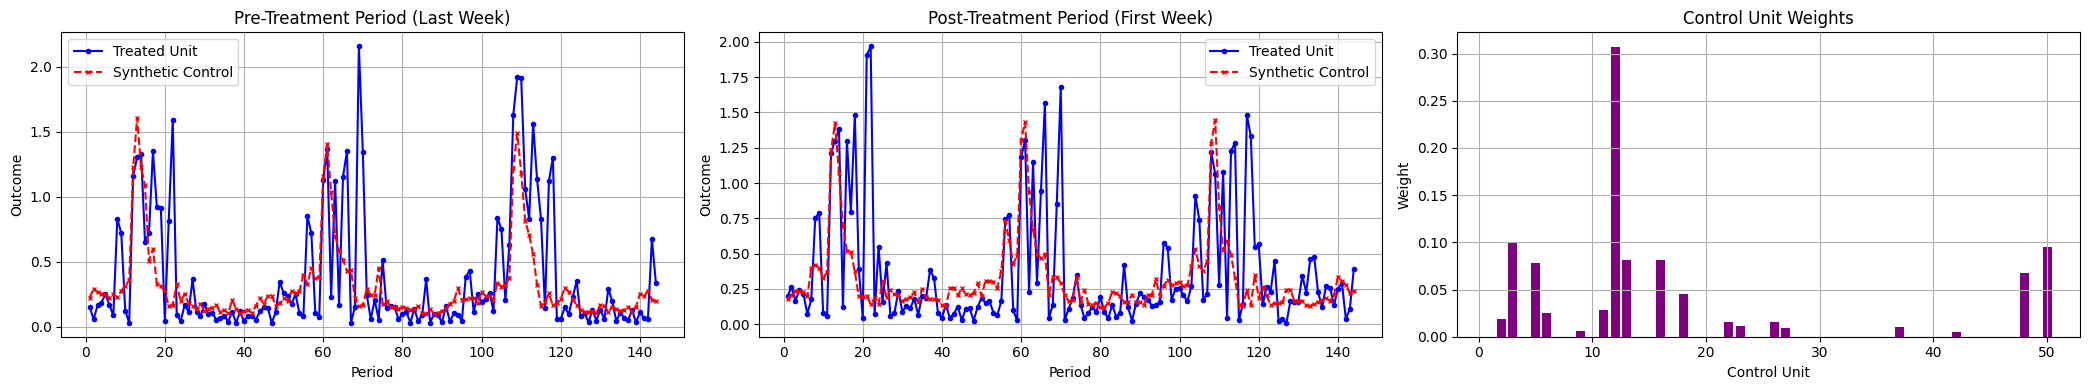

In [138]:
from sklearn.metrics.pairwise import cosine_similarity
from dtaidistance import dtw

def prepare_data_for_synthetic_control_with_clustering(path, top_k=5):
    # Step 1: Load the dataset
    df = pd.read_csv(path, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)

    # Step 2: Drop 'load_*' columns with any missing values
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")
    df = df[['Date'] + clean_loads]

    # Step 3: Select the treated and control units
    treated_unit = df.columns[1]
    control_units = [col for col in df.columns if col.startswith('load_') and col != treated_unit]

    # Step 4: Calculate similarity scores
    similarity_scores = {}
    treated_series = df[treated_unit].values.reshape(1, -1)  # Shape: (1, T)
    for unit in control_units:
        control_series = df[unit].values.reshape(1, -1)  # Shape: (1, T)
        similarity = cosine_similarity(treated_series, control_series)[0, 0]#-dtw.distance(treated_series[0][:300], control_series[0][:300])#np.corrcoef(treated_series[0], control_series[0])[0, 1]#-np.linalg.norm(treated_series[0] - control_series[0])
        similarity_scores[unit] = similarity

    # Step 5: Select top-k most similar control units
    top_k_units = sorted(similarity_scores, key=similarity_scores.get, reverse=True)[:top_k]
    print(f"Top {top_k} similar control units: {top_k_units}")

    # Step 6: Define pre-treatment and post-treatment periods
    split_index = int(len(df) * 0.8)  # 80% for pre-treatment
    pre_treatment, post_treatment = df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

    # Step 7: Prepare the data matrices
    Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
    Y0_pre = pre_treatment[top_k_units].values.T  # Shape: (J, T0)

    Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
    Y0_post = post_treatment[top_k_units].values.T  # Shape: (J, T1)

    return Y1_pre, Y0_pre, Y1_post, Y0_post

Y1_pre, Y0_pre, Y1_post, Y0_post = prepare_data_for_synthetic_control_with_clustering("../../data/Final_Energy_dataset.csv", top_k=50)

# 2. Compute optimal weights
def compute_synthetic_control_weights_L1(Y1_pre, Y0_pre):
    T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
    J = Y0_pre.shape[0]   # Number of control units

    # Create a Gurobi model
    model = gp.Model("Synthetic_Control_L1")
    model.setParam('OutputFlag', 0) # Suppress Gurobi output

    # Add variables W_j >= 0 for each control unit
    W = model.addVars(J, lb=0.0, name="W")

    # Add auxiliary variables e_plus_t >= 0 and e_minus_t >=0 for each pre-treatment period
    e_plus = model.addVars(T0, lb=0.0, name="e_plus")
    e_minus = model.addVars(T0, lb=0.0, name="e_minus")

    # Add the constraint that the weights sum to one
    model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

    # Add constraints to define e_plus and e_minus
    for t in range(T0):
        # Calculate the discrepancy: Y1_pre[t] - sum_j W[j] * Y0_pre[j, t]
        discrepancy = Y1_pre[t] - gp.quicksum(W[j] * Y0_pre[j, t] for j in range(J))
        # Enforce discrepancy = e_plus[t] - e_minus[t]
        model.addConstr(discrepancy == e_plus[t] - e_minus[t], name=f"discrepancy_{t}")

    # Set the objective function to minimize the sum of e_plus and e_minus
    obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimal weights
        W_opt = np.array([W[j].X for j in range(J)])
        return W_opt
    else:
        raise ValueError("Optimization was not successful. Please check the model and data.")
weights = compute_synthetic_control_weights_L1(Y1_pre, Y0_pre)

#3. Calculate synthetic control data
def compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights):
    Y_synthetic_pre = np.dot(weights, Y0_pre)
    Y_synthetic_post = np.dot(weights, Y0_post)  # Shape: (T1,)
    return Y_synthetic_pre, Y_synthetic_post
Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights)

#4. Evaluate and plot
def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
    # Calculate metrics for pre-treatment
    mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
    metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
    
    # Calculate metrics for post-treatment
    mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
    rmse_post = np.sqrt(mse_post)
    mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
    metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
    
    return metrics_pre, metrics_post

metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
#print("Pre-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_pre.items()})
print("Post-Treatment Metrics:", {k: round(v, 4) for k, v in metrics_post.items()})
print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
    periods_to_plot = 3*48  # Number of periods to represent one week
    
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
    
    post_treatment_actual = Y1_post[:periods_to_plot]
    post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Third Subplot: Weights Values
    axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
    axes[2].set_title('Control Unit Weights')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

# 4. Synthetic Control - Multiple Weights (Day Types)

In [6]:
def prepare_data_for_synthetic_control_day_types(path, n_cluster=2, group_by="hour", num_shifts=1):
    """
    Prepare data for synthetic control method with day type clustering and time shifts.
    
    Args:
        path (str): Path to the CSV file
        n_cluster (int): Number of clusters for day types
        group_by (str): Clustering basis - "weekday" or "hour"
        num_shifts (int): Number of shifts in each direction (default=3)
    """
    # Step 1: Load the dataset
    df = pd.read_csv(path, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
    
    # Step 2: Drop 'load_*' columns with any missing values
    load_columns = [col for col in df.columns if col.startswith('load_')]
    clean_loads = [col for col in load_columns if df[col].notna().all()]
    dropped_loads = set(load_columns) - set(clean_loads)
    if dropped_loads:
        print(f"Dropped load columns with missing values: {dropped_loads}")
        
    # Step 3: Create enhanced dataframe with shifted versions
    treated_unit = clean_loads[0]
    control_units = clean_loads[1:]
    
    # Create a dictionary to store all the shifted data
    data_dict = {'Date': df['Date'], treated_unit: df[treated_unit]}
    
    # Add original and shifted versions for each control unit
    for control in control_units:
        # Add original version
        data_dict[f"{control}_orig"] = df[control]
        
        # Add backward shifts
        for i in range(1, num_shifts + 1):
            data_dict[f"{control}_backward_{i}"] = df[control].shift(-i)
            
        # Add forward shifts
        for i in range(1, num_shifts + 1):
            data_dict[f"{control}_forward_{i}"] = df[control].shift(i)
    
    # Create enhanced DataFrame all at once to avoid fragmentation
    enhanced_df = pd.DataFrame(data_dict).dropna()
    
    # Get all control column names with suffixes
    all_control_units = []
    for control in control_units:
        all_control_units.append(f"{control}_orig")
        all_control_units.extend([f"{control}_backward_{i}" for i in range(1, num_shifts + 1)])
        all_control_units.extend([f"{control}_forward_{i}" for i in range(1, num_shifts + 1)])
    
    # Step 4: Cluster weekdays/hours
    group_type = None
    if group_by == "weekday":
        group_type = enhanced_df['Date'].dt.weekday
    elif group_by == "hour":
        group_type = enhanced_df['Date'].dt.hour
    else:
        raise ValueError("Select 'hour' or 'weekday' for group_by parameter")
    
    # Extract features for clustering (using original versions only for clustering)
    original_columns = [col for col in enhanced_df.columns if col.endswith('_orig') or col == treated_unit]
    cluster_features = enhanced_df.groupby(group_type)[original_columns].mean()
    
    # Standardize features for clustering
    scaler = StandardScaler()
    cluster_features_scaled = scaler.fit_transform(cluster_features)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    clusters = kmeans.fit_predict(cluster_features_scaled)
    
    # Map original types to clusters
    cluster_map = {day: cluster for day, cluster in enumerate(clusters)}
    
    # Add cluster column to dataframe
    enhanced_df['TypeCluster'] = group_type.map(cluster_map)
    
    # Print information about the dataset
    total_versions = 2 * num_shifts + 1
    print(f"Number of control units: {len(control_units)}")
    print(f"Versions per control unit: {total_versions} ({num_shifts} backward, 1 original, {num_shifts} forward)")
    print(f"Total number of control unit versions: {len(all_control_units)}")
    
    # Print cluster mapping
    print("\nCluster Mapping:")
    for type, cluster in cluster_map.items():
        print(f"Cluster {type} -> Cluster {cluster}")
    
    # Prepare results dictionary
    results = {}
    
    # Process each day type cluster
    for day_type_cluster in range(n_cluster):
        # Filter for the specific day type cluster
        df_day_type = enhanced_df[enhanced_df['TypeCluster'] == day_type_cluster].copy()
        
        # Define pre-treatment and post-treatment periods
        split_index = int(len(df_day_type) * 0.8)  # 80% for pre-treatment
        pre_treatment = df_day_type.iloc[:split_index].copy()
        post_treatment = df_day_type.iloc[split_index:].copy()
        
        # Prepare the data matrices
        Y1_pre = pre_treatment[treated_unit].values  # Shape: (T0,)
        Y0_pre = pre_treatment[all_control_units].values.T  # Shape: ((2*num_shifts+1)*J, T0)
        Y1_post = post_treatment[treated_unit].values  # Shape: (T1,)
        Y0_post = post_treatment[all_control_units].values.T  # Shape: ((2*num_shifts+1)*J, T1)
        
        # Store results for the current day type cluster
        results[f'TypeCluster_{day_type_cluster}'] = (Y1_pre, Y0_pre, Y1_post, Y0_post)
    
    return results

# For default settings (2 clusters, weekday grouping, 3 shifts):
results = prepare_data_for_synthetic_control_day_types("../../data/Final_Energy_dataset.csv")

Dropped load columns with missing values: {'load_2'}
Number of control units: 298
Versions per control unit: 3 (1 backward, 1 original, 1 forward)
Total number of control unit versions: 894

Cluster Mapping:
Cluster 0 -> Cluster 0
Cluster 1 -> Cluster 0
Cluster 2 -> Cluster 0
Cluster 3 -> Cluster 0
Cluster 4 -> Cluster 0
Cluster 5 -> Cluster 0
Cluster 6 -> Cluster 0
Cluster 7 -> Cluster 0
Cluster 8 -> Cluster 0
Cluster 9 -> Cluster 0
Cluster 10 -> Cluster 0
Cluster 11 -> Cluster 0
Cluster 12 -> Cluster 0
Cluster 13 -> Cluster 0
Cluster 14 -> Cluster 0
Cluster 15 -> Cluster 0
Cluster 16 -> Cluster 0
Cluster 17 -> Cluster 1
Cluster 18 -> Cluster 1
Cluster 19 -> Cluster 1
Cluster 20 -> Cluster 1
Cluster 21 -> Cluster 1
Cluster 22 -> Cluster 1
Cluster 23 -> Cluster 0


Post-Treatment Metrics cluster TypeCluster_0: {'MSE': 0.1366, 'RMSE': 0.3696, 'MAE': 0.2488}
Number of weights > 0.0: 32


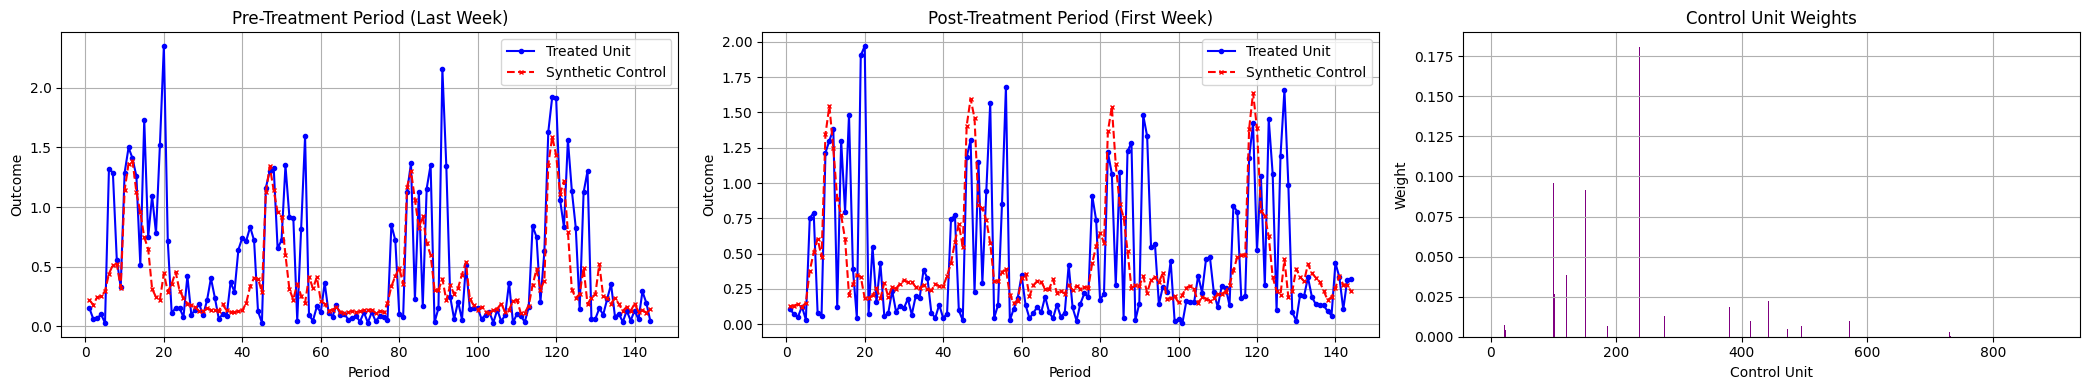

Post-Treatment Metrics cluster TypeCluster_1: {'MSE': 0.0291, 'RMSE': 0.1705, 'MAE': 0.1058}
Number of weights > 0.0: 82


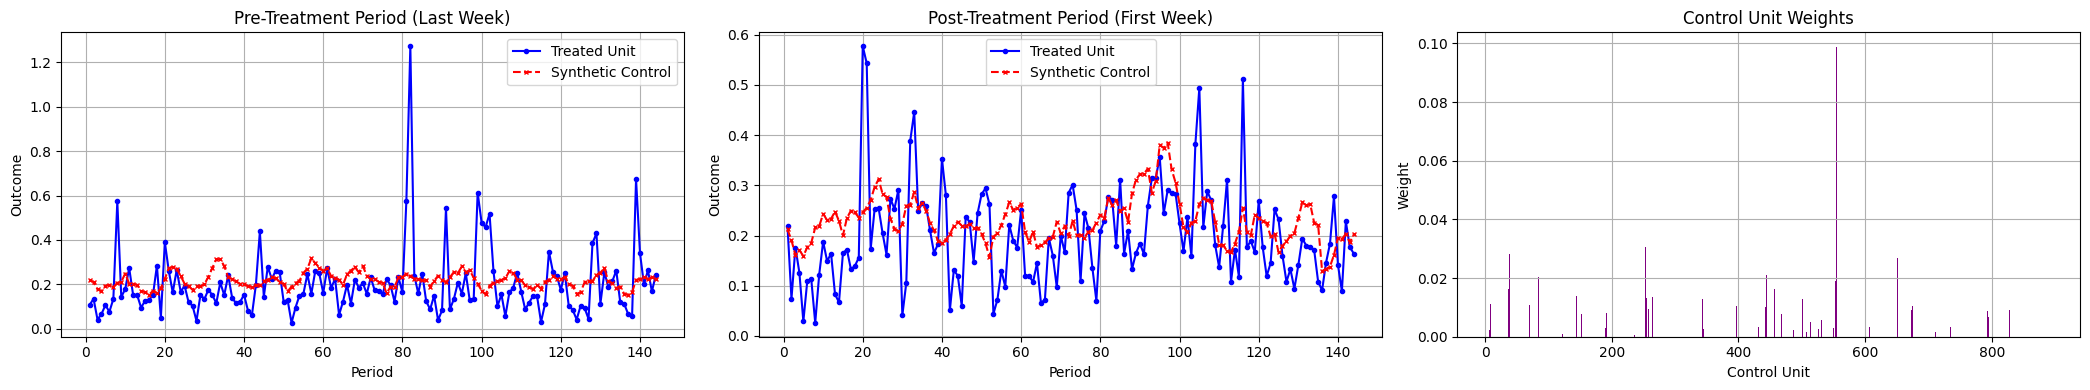


Weighted Average Post-Treatment Metrics:
MSE: 0.1097 ± 0.0466
RMSE: 0.3198 ± 0.0862
MAE: 0.2130 ± 0.0619


In [7]:
all_metrics_post = {}
cluster_sizes = {}
for cluster_key, (Y1_pre, Y0_pre, Y1_post, Y0_post) in results.items():
   
    # 2. Compute optimal weights
    def compute_synthetic_control_weights_L1(Y1_pre, Y0_pre):
        # Ensure proper shapes
        Y1_pre = np.asarray(Y1_pre)
        Y0_pre = np.asarray(Y0_pre)
        
        T0 = Y1_pre.shape[0]  # Number of pre-treatment periods
        J = Y0_pre.shape[0]   # Number of control units

        # Create a Gurobi model
        model = gp.Model("Synthetic_Control_L1")
        model.setParam('OutputFlag', 0) # Suppress Gurobi output

        # Add variables W_j >= 0 for each control unit
        W = model.addVars(J, lb=0.0, name="W")

        # Add auxiliary variables e_plus_t >= 0 and e_minus_t >=0 for each pre-treatment period
        e_plus = model.addVars(T0, lb=0.0, name="e_plus")
        e_minus = model.addVars(T0, lb=0.0, name="e_minus")

        # Add the constraint that the weights sum to one
        model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1, name="sum_to_one")

        # Add constraints to define e_plus and e_minus
        for t in range(T0):
            # Calculate the discrepancy: Y1_pre[t] - sum_j W[j] * Y0_pre[j, t]
            discrepancy = Y1_pre[t] - gp.quicksum(W[j] * Y0_pre[j, t] for j in range(J))
            # Enforce discrepancy = e_plus[t] - e_minus[t]
            model.addConstr(discrepancy == e_plus[t] - e_minus[t], name=f"discrepancy_{t}")

        # Set the objective function to minimize the sum of e_plus and e_minus
        obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
        model.setObjective(obj, GRB.MINIMIZE)

        # Optimize the model
        model.optimize()

        # Check if the optimization was successful
        if model.status == GRB.OPTIMAL:
            # Retrieve the optimal weights
            W_opt = np.array([W[j].X for j in range(J)])
            return W_opt
        else:
            raise ValueError("Optimization was not successful. Please check the model and data.")

    weights = compute_synthetic_control_weights_L1(Y1_pre, Y0_pre)

    #3. Calculate synthetic control data
    def compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights):
        Y_synthetic_pre = np.dot(weights, Y0_pre)
        Y_synthetic_post = np.dot(weights, Y0_post)  # Shape: (T1,)
        return Y_synthetic_pre, Y_synthetic_post
    Y_synthetic_pre, Y_synthetic_post = compute_synthetic_pre_post_treatment(Y0_pre, Y0_post, weights)

    #4. Evaluate and plot
    def evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post):
        # Calculate metrics for pre-treatment
        mse_pre = np.mean((Y1_pre - Y_synthetic_pre) ** 2)
        rmse_pre = np.sqrt(mse_pre)
        mae_pre = np.mean(np.abs(Y1_pre - Y_synthetic_pre))
        metrics_pre = {'MSE': mse_pre, 'RMSE': rmse_pre, 'MAE': mae_pre}
        
        # Calculate metrics for post-treatment
        mse_post = np.mean((Y1_post - Y_synthetic_post) ** 2)
        rmse_post = np.sqrt(mse_post)
        mae_post = np.mean(np.abs(Y1_post - Y_synthetic_post))
        metrics_post = {'MSE': mse_post, 'RMSE': rmse_post, 'MAE': mae_post}
        
        return metrics_pre, metrics_post

    metrics_pre, metrics_post = evaluate_metrics_pre_post(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post)
    print(f"Post-Treatment Metrics cluster {cluster_key}:", {k: round(v, 4) for k, v in metrics_post.items()})
    print(f"Number of weights > 0.0: {np.sum(weights > 0.0)}")

    def plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights):
    
        periods_to_plot = 3*48  # Number of periods to represent one week
        
        # Prepare data slices
        pre_treatment_actual = Y1_pre[-periods_to_plot:]
        pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
        
        post_treatment_actual = Y1_post[:periods_to_plot]
        post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
        
        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(21, 4))
        
        # Pre-Treatment Plot
        axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
        axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
        axes[0].set_title('Pre-Treatment Period (Last Week)')
        axes[0].set_xlabel('Period')
        axes[0].set_ylabel('Outcome')
        axes[0].legend()
        axes[0].grid(True)
        
        # Post-Treatment Plot
        axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual, label='Treated Unit', color='blue', marker='o', markersize=3)
        axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic, label='Synthetic Control', color='red', linestyle='--', marker='x', markersize=3)
        axes[1].set_title('Post-Treatment Period (First Week)')
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Outcome')
        axes[1].legend()
        axes[1].grid(True)
        
        # Third Subplot: Weights Values
        axes[2].bar(range(1, len(weights) + 1), weights, color='purple')
        axes[2].set_title('Control Unit Weights')
        axes[2].set_xlabel('Control Unit')
        axes[2].set_ylabel('Weight')
        axes[2].grid(True)
        
        # Adjust layout and display the plots
        plt.tight_layout()
        plt.show()

    plot_synthetic_control(Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post, weights)

   # Store cluster size
    cluster_sizes[cluster_key] = len(Y1_post)

    # Inside the iteration loop, after calculating metrics
    if not all_metrics_post:
        all_metrics_post = {k: [v] for k, v in metrics_post.items()}
    else:
        for k in all_metrics_post:
            all_metrics_post[k].append(metrics_post[k])

# After the loop, calculate and print weighted average post-treatment metrics
print("\nWeighted Average Post-Treatment Metrics:")
for metric_name, values in all_metrics_post.items():
    # Calculate weighted mean
    weights = [cluster_sizes[key] for key in results.keys()]
    weighted_mean = np.average(values, weights=weights)
    
    # Calculate weighted standard deviation
    # Using the formula: sqrt(sum(w * (x - weighted_mean)^2) / sum(w))
    weighted_var = np.average((values - weighted_mean)**2, weights=weights)
    weighted_std = np.sqrt(weighted_var)
    
    print(f"{metric_name}: {weighted_mean:.4f} ± {weighted_std:.4f}")

# 5. Synthetic Control - Weihgt Selection -> Slack Variables?

# Synthetic Control with Sensitivity

Dropped load columns with missing values: {'load_2'}
Cluster Mapping:
Cluster 0 -> Cluster 0
Cluster 1 -> Cluster 0
Cluster 2 -> Cluster 0
Cluster 3 -> Cluster 0
Cluster 4 -> Cluster 0
Cluster 5 -> Cluster 1
Cluster 6 -> Cluster 1


C:\Users\rs1044\AppData\Local\Temp\ipykernel_17976\46523152.py:111: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  obj += lambda_sparse * gp.quicksum(sparse_vars)


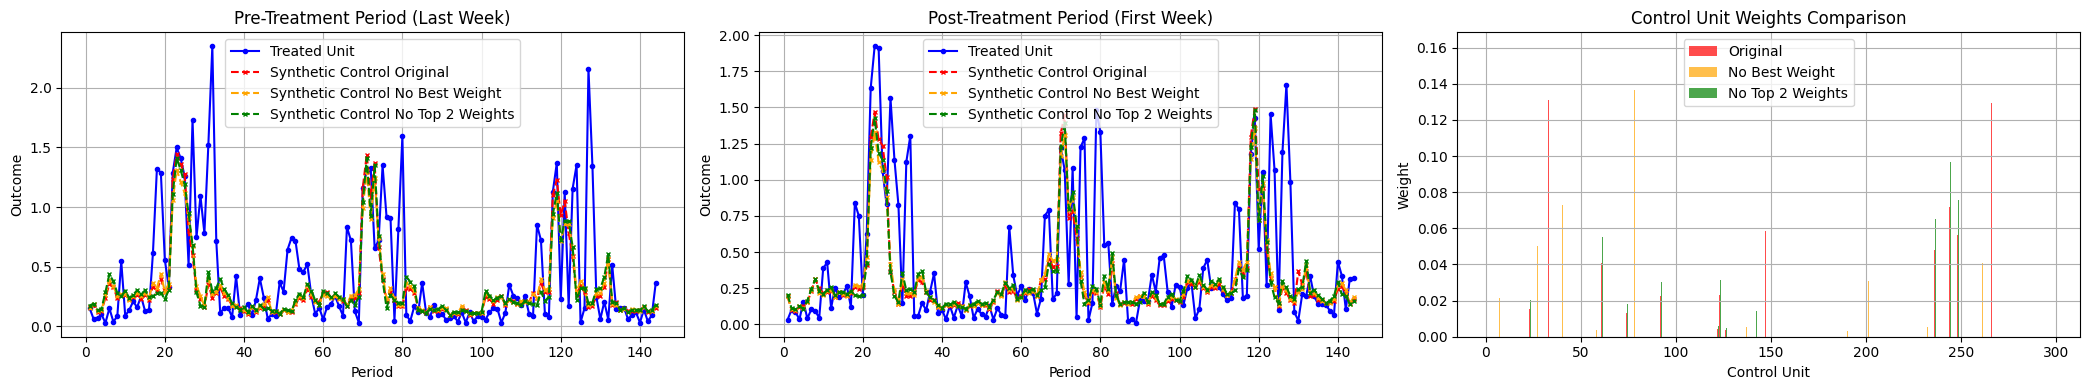


Metrics for cluster TypeCluster_0:
Original:  {'MSE': 0.1294, 'RMSE': 0.3597, 'MAE': 0.2283}
No Best Weight:  {'MSE': 0.1315, 'RMSE': 0.3626, 'MAE': 0.2324}
No Top 2 Weights:  {'MSE': 0.1331, 'RMSE': 0.3648, 'MAE': 0.2345}


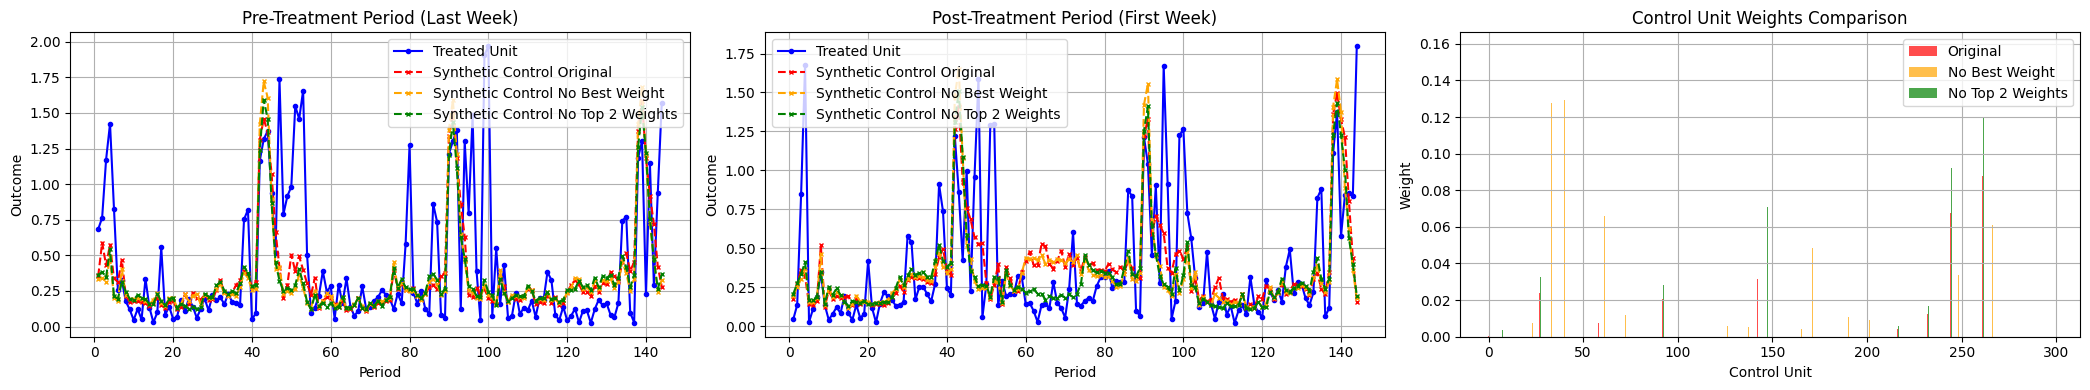


Metrics for cluster TypeCluster_1:
Original:  {'MSE': 0.1234, 'RMSE': 0.3512, 'MAE': 0.2254}
No Best Weight:  {'MSE': 0.1292, 'RMSE': 0.3595, 'MAE': 0.2347}
No Top 2 Weights:  {'MSE': 0.1263, 'RMSE': 0.3554, 'MAE': 0.2291}


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def compute_synthetic_control_with_exclusions(Y1_pre, Y0_pre, Y1_post, Y0_post, initial_weights):
    results = []
    weights_series = []
    
    # Round 1: Original weights
    weights = initial_weights.copy()
    Y_synthetic_pre = np.dot(weights, Y0_pre)
    Y_synthetic_post = np.dot(weights, Y0_post)
    results.append((Y_synthetic_pre, Y_synthetic_post))
    weights_series.append(weights)
    
    # Round 2: Exclude best weight
    best_idx = np.argmax(weights)
    weights_r2 = weights.copy()
    weights_r2[best_idx] = 0
    # Normalize remaining weights to sum to 1
    if np.sum(weights_r2) > 0:
        weights_r2 = weights_r2 / np.sum(weights_r2)
    Y_synthetic_pre = np.dot(weights_r2, Y0_pre)
    Y_synthetic_post = np.dot(weights_r2, Y0_post)
    results.append((Y_synthetic_pre, Y_synthetic_post))
    weights_series.append(weights_r2)
    
    # Round 3: Exclude second best weight
    remaining_weights = weights[weights > 0]
    if len(remaining_weights) >= 2:
        second_best_idx = np.argsort(weights)[-2]
        weights_r3 = weights.copy()
        weights_r3[best_idx] = 0
        weights_r3[second_best_idx] = 0
        # Normalize remaining weights to sum to 1
        if np.sum(weights_r3) > 0:
            weights_r3 = weights_r3 / np.sum(weights_r3)
        Y_synthetic_pre = np.dot(weights_r3, Y0_pre)
        Y_synthetic_post = np.dot(weights_r3, Y0_post)
    else:
        # If not enough non-zero weights, use previous results
        weights_r3 = weights_r2
        Y_synthetic_pre, Y_synthetic_post = results[-1]
    
    results.append((Y_synthetic_pre, Y_synthetic_post))
    weights_series.append(weights_r3)
    
    return results, weights_series

def plot_synthetic_control_uncertainty(Y1_pre, Y1_post, synthetic_results, weights_series, periods_to_plot=3*48):
    # Prepare data slices
    pre_treatment_actual = Y1_pre[-periods_to_plot:]
    post_treatment_actual = Y1_post[:periods_to_plot]
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    
    # Colors for different synthetic controls
    colors = ['red', 'orange', 'green']
    labels = ['Original', 'No Best Weight', 'No Top 2 Weights']
    
    # Pre-Treatment Plot
    axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_actual, 
                 label='Treated Unit', color='blue', marker='o', markersize=3)
    
    for i, (Y_synthetic_pre, _) in enumerate(synthetic_results):
        pre_treatment_synthetic = Y_synthetic_pre[-periods_to_plot:]
        axes[0].plot(range(1, periods_to_plot + 1), pre_treatment_synthetic,
                    label=f'Synthetic Control {labels[i]}', color=colors[i],
                    linestyle='--', marker='x', markersize=3)
    
    axes[0].set_title('Pre-Treatment Period (Last Week)')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Outcome')
    axes[0].legend()
    axes[0].grid(True)
    
    # Post-Treatment Plot
    axes[1].plot(range(1, periods_to_plot + 1), post_treatment_actual,
                 label='Treated Unit', color='blue', marker='o', markersize=3)
    
    for i, (_, Y_synthetic_post) in enumerate(synthetic_results):
        post_treatment_synthetic = Y_synthetic_post[:periods_to_plot]
        axes[1].plot(range(1, periods_to_plot + 1), post_treatment_synthetic,
                    label=f'Synthetic Control {labels[i]}', color=colors[i],
                    linestyle='--', marker='x', markersize=3)
    
    axes[1].set_title('Post-Treatment Period (First Week)')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Outcome')
    axes[1].legend()
    axes[1].grid(True)
    
    # Weights Plot
    bar_width = 0.25
    x = np.arange(len(weights_series[0]))
    
    for i, weights in enumerate(weights_series):
        axes[2].bar(x + i*bar_width, weights, bar_width,
                   label=labels[i], color=colors[i], alpha=0.7)
    
    axes[2].set_title('Control Unit Weights Comparison')
    axes[2].set_xlabel('Control Unit')
    axes[2].set_ylabel('Weight')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Modified main loop
results = prepare_data_for_synthetic_control_day_types("../../data/Final_Energy_dataset.csv")

all_metrics_post = {}
cluster_sizes = {}
for cluster_key, (Y1_pre, Y0_pre, Y1_post, Y0_post) in results.items():
    # Compute original weights
    weights = compute_synthetic_control_weights_L1(Y1_pre, Y0_pre)
    
    # Compute synthetic controls with weight exclusions
    synthetic_results, weights_series = compute_synthetic_control_with_exclusions(
        Y1_pre, Y0_pre, Y1_post, Y0_post, weights
    )
    
    # Plot results with uncertainty
    plot_synthetic_control_uncertainty(Y1_pre, Y1_post, synthetic_results, weights_series)
    
    # Calculate metrics for each version
    metrics_versions = []
    for Y_synthetic_pre, Y_synthetic_post in synthetic_results:
        metrics_pre, metrics_post = evaluate_metrics_pre_post(
            Y1_pre, Y_synthetic_pre, Y1_post, Y_synthetic_post
        )
        metrics_versions.append(metrics_post)
    
    print(f"\nMetrics for cluster {cluster_key}:")
    for i, metrics in enumerate(['Original', 'No Best Weight', 'No Top 2 Weights']):
        print(f"{metrics}: ", {k: round(v, 4) for k, v in metrics_versions[i].items()})
    
    # Store cluster size
    cluster_sizes[cluster_key] = len(Y1_post)